In [42]:
import pandas as pd
from sklearn.decomposition import PCA
from stanfordcorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP(r'../stanford-corenlp-full')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [43]:
# load data and cut out information we don't want
data_df = (pd.read_excel("Labeled Turns.xlsx"))[["Call_ID", "Time-ordered_segment","S_content","Ask"]]
data_df["S_content"] = data_df["S_content"].str.lower()
data_df["S_content"] = data_df["S_content"].str.replace("#","")
print(data_df["Ask"].value_counts())

# load up the dictionary
dict_df = pd.read_excel("Ask Specificity Dict.xlsx")
dict_df["Phrases"] = dict_df["Phrases"].str.lower()

0    539
1     32
2     24
3     19
Name: Ask, dtype: int64


The above code loads all of the data using pandas. An interesting thing to note from the output is that there are 75 turns labeled for some sort of ask specificity.

The cell below turns it into an array. The cell after that defines a function for processing based on the stanford parser

In [44]:
data_array = data_df.values
dict_array = [x[0] for x in dict_df.values]
print(dict_array)

['around 1', 'around 10', 'around 11', 'around 12', 'around 2', 'around 3', 'around 4', 'around 9', 'around eleven', 'around four', 'around nine', 'around noon', 'around one', 'around ten', 'around three', 'around twelve', 'around two', 'at 1', 'at 10', 'at 11', 'at 12', 'at 2', 'at 3', 'at 4', 'at 9', 'at eleven', 'at four', 'at nine', 'at noon', 'at one', 'at some point', 'at ten', 'at three', 'at twelve', 'at two', 'calendar ', 'could come in', 'fifteen or twenty minutes', 'friday ', 'hour', 'minutes', 'monday', 'next couple of weeks', 'next couple weeks', 'next friday', 'next friday or', 'next monday', 'next monday or', 'next month ', 'next several weeks', 'next thursday', 'next thursday or ', 'next tuesday ', 'next tuesday or', 'next wednesday', 'next wednesday or', 'next week', 'next week or the following', 'rep come out', 'rep to meet with ', 'some time', 'stop back in', 'stop by', 'stop in', 'the week of the', 'this friday', 'this monday', 'this month', 'this thursday', 'this t

In [45]:
def process_text(txt):
    
    output = [0,0,0,0,0,0,0,0]
    tagged_line = nlp.pos_tag(txt)
    one_back = 'NONE'
    two_back = 'NONE'
    
    #bitty question: for last two do I need the dependency parser or are those just straight up one after the other?
    
    for pair in tagged_line:
        if pair[1] == 'CD':
            output[0] = 1
            
        if pair[1] == 'NN':
            output[1] = 1
            
        if pair[1] == 'NNP':
            output[2] = 1
            
        if pair[1] == 'IN' and one_back == 'NN':
            output[3] = 1
        
        if pair[1] == 'IN' and one_back == 'VB' and two_back != 'PRP':
            output[4] = 1
            
        if pair[1] == 'VB' and one_back == 'MD' and two_back != 'PRP':
            output[5] = 1
            
        if pair[1] == 'RP' and one_back == 'VBN' and two_back == 'NN':
            output[6] = 1
            
        if pair[1] == 'IN' and one_back == 'RP' and two_back == 'VB':
            output[7] = 1
        
        two_back = one_back
        one_back = pair[1]
        
    return output

The next cell runs through and uses the stanford parser on every first Salesperson turn where it finds something from the dictionary. It also associates an index with the output.

In [46]:
current_call_id = data_array[0][0]
found_turn = 0

# there are 8 rules plus the length of the dictionary
processed_rows = []
idx = 0

for row in data_array:
    if row[0] == current_call_id and found_turn == 0:
        
        if any(phrase in row[2] for phrase in dict_array):
            output = process_text(row[2])
            processed_rows.append((idx,output))
            found_turn = 1
        
    if row[0] != current_call_id:
        found_turn = 0
        current_call_id = row[0]
        
        if any(phrase in row[2] for phrase in dict_array):
            output = process_text(row[2])
            processed_rows.append((idx,output))
            found_turn = 1
        
    idx += 1
    

# for row in data_array:
#     if row[0] == current_call_id and found_turn == 0:
        
#         output = process_text(row[2])
        
#         if 1 in output:
#             processed_rows.append((idx,output))
#             found_turn = 1
        
#     if row[0] != current_call_id:
#         found_turn = 0
#         current_call_id = row[0]
        
#         output = process_text(row[2])
        
#         if 1 in output:
#             processed_rows.append((idx,output))
#             found_turn = 1
        
#     idx += 1
    

The next cell prints out how many rows we ended up tagging for ask specificty by following that rule. It only brings up 62 which is a little short of 75. The numbers that print along with that show the tuple with an index and a stanford parser produced feature vector for that row in the data array.

In [47]:
print(len(processed_rows))
print(processed_rows[0])

62
(4, [1, 1, 1, 1, 1, 1, 0, 0])


Plot the actual labels from the turns we picked out using the rules. Some of these come out as zero which means we picked up a few turns that weren't supposed to be picked up.

62


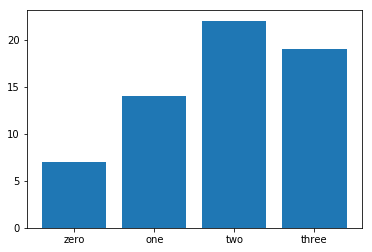

In [48]:
labels=[data_array[x][3] for x in [t[0] for t in processed_rows]]
zero_count = 0
one_count = 0
two_count = 0
three_count = 0

for x in labels:
    if x == 0:
        zero_count += 1
    elif x == 1:
        one_count += 1
    elif x == 2:
        two_count += 1
    elif x == 3:
        three_count += 1

print(zero_count+one_count+two_count+three_count)
plt.bar(["zero","one","two","three"],[zero_count,one_count,two_count,three_count])
plt.show()

I went ahead and ran PCA to reduce the feature vector from 8 to 2 just to see if it even looks seperable.
PCA doesn't work quite as well on One hot encoded vectors which you can see in the plot below.
Many points land on top of each other so I plotted each set seperatly to see what it looks like.

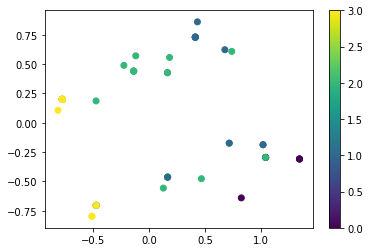

In [49]:
pca = PCA(2)
projected_points = pca.fit_transform([t[1] for t in processed_rows])
plt.scatter(projected_points[:,0], projected_points[:,1],c=labels)
plt.colorbar()
plt.show()

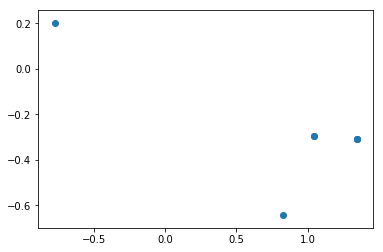

In [50]:

class_points = [x[0] for x in zip(projected_points, labels) if x[1]==0]
plt.scatter([x[0] for x in class_points],[x[1] for x in class_points])
plt.show()

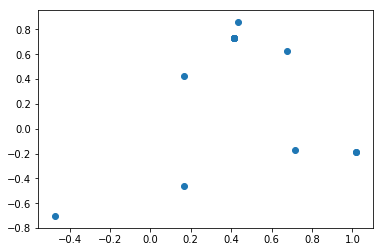

In [51]:
class_points = [x[0] for x in zip(projected_points, labels) if x[1]==1]
plt.scatter([x[0] for x in class_points],[x[1] for x in class_points])
plt.show()

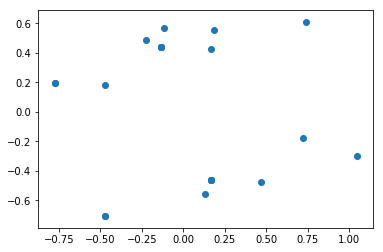

In [52]:
class_points = [x[0] for x in zip(projected_points, labels) if x[1]==2]
plt.scatter([x[0] for x in class_points],[x[1] for x in class_points])
plt.show()

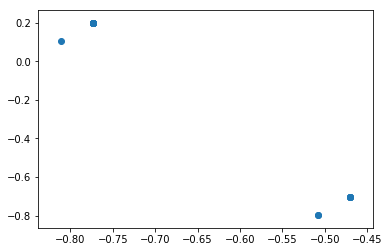

In [53]:
class_points = [x[0] for x in zip(projected_points, labels) if x[1]==3]
plt.scatter([x[0] for x in class_points],[x[1] for x in class_points])
plt.show()

Basically what the plots above show is that there are members of each class all around the map and that the features aren't super seperable. The next few cells go ahead and run predictions anyway just to see where we're at

In [54]:
features = [t[1] for t in processed_rows]

In [55]:
clf = DecisionTreeClassifier(random_state=0)
split = int(np.floor(len(features)*.7))
print(len(features[split:]))
clf.fit(features[:split], labels[:split])
clf.score(features[split:], labels[split:])

19


0.7894736842105263

The above cell shows an accuracy of 78 percent on turns that are already labeled as having ask specificity. Basically, if we knew that a turn had ask specificity, we could predict which type with about 78 percent accuracy. The next couple of cells will try to predict just if ask specificity is present, but not which type.

In [56]:
current_call_id = data_array[0][0]
found_turn = 0

processed_rows = []
idx = 0

for row in data_array:
    if row[0] == current_call_id and found_turn == 0:
        
        if any(phrase in row[2] for phrase in dict_array):
            output = process_text(row[2])
            processed_rows.append((idx,output))
            found_turn = 1
            
        else:
            processed_rows.append((idx,[0,0,0,0,0,0,0,0]))
        
    if row[0] == current_call_id and found_turn == 1:
            processed_rows.append((idx,[0,0,0,0,0,0,0,0]))
            
    if row[0] != current_call_id:
        found_turn = 0
        current_call_id = row[0]
        
        if any(phrase in row[2] for phrase in dict_array):
            output = process_text(row[2])
            processed_rows.append((idx,output))
            found_turn = 1
        
    idx += 1
  

In [57]:
features = [t[1] for t in processed_rows]
labels=[data_array[x][3] for x in [t[0] for t in processed_rows]]

In [58]:
clf = DecisionTreeClassifier(random_state=0)
split = int(np.floor(len(features)*.7))
print(len(features[split:]))
clf.fit(features[:split], labels[:split])
clf.score(features[split:], labels[split:])

180


0.8555555555555555

The above cell shows that based on the rules for ask specificity, we can predict if ask specificty is actually present with about 85 percent accuracy. Given the charts from earlier in the notebook, this is actually better than I expected.